#### Graph plotting notebook

Output is saved as pdfs in the ```graphs/``` folder.

##### Graph data

When generating the graphs, we use data from only the test set when computing accuracy, and from both the full dataset and the test subset for creating the histograms, allowing us to visualise the difference, and therefore assess generalisability.

##### Identifying play sessions

Play sessions are defined as follows: A series of 1 or more consecutive games with no more than 2 hours between any two matches (todo: adjust # hours). We compare the average accuracy of each model for the games which are the 1st, 2nd, ..., (n+)st in a session. The same grouping is used for the win/loss streak accuracy comparison, except that we are identifying the streak relative to the match prior to the sample target. In other words, we analyse the accuracy when predicting the game immediately following a length-(1, 2, ..., n+) streak. This means we avoid considering or overvaluing models, or the tendencies of a model, which simply follow the temporal autocorrelation within the validation set (i.e., a rule that simply predicts the same outcome as the preceding match), and thus overfit to recent trends of specific features.

Todo:
Predict for all sequence elements, compute normalised session percentiles; use sessions of 3+ games (for the 33% percentile graph), 5+ games (for the 20%) and 10+ games (for the 10%). This makes efficient use of the data and also allows analysis along the dimension of minimum session length.

##### Filtering out outliers/samples with missing data

When identifying play sessions and win/loss streaks, and comparing accuracy of the following game, we exclude samples for which we do not have any recent match data, and those for which we do not have enough recent matches for session/streak idenitfication. For sessions, these are samples with less than 2 total sessions in the recent match list. For streaks, these are samples with fewer than 2 total streaks (of either kind). While it is often the case that empty/1-samples recent match lists simply indicate that the player has not played in a significant amount of time, and therefore their recent matches are irrelevant and we can safely analyse predictions for the player, this is not guaranteed (op.gg may be inaccurate), and, additionally, we are not so interested in analysing the accuracy for the case of a player returning from a long period of inactivity, as momentum is much less of a factor in these cases.

##### Player tendency analysis

We group samples by some heuristics which correlate with momentum/tilt tendencies of players, and compute model accuracy for these groups, shedding light on where the model is most effective and who for. We perform an analysis along three dimensions: average player session length (in number of games), average player win streak size and average player loss streak size. Since we do not have enough samples for each player to assign every player accurate metrics, we take the subset of test samples which belong to players who have at least a total of 10 full-length sessions in the test set.

In [2]:
from new_model import *
from Graphing import *
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [42]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d_all")
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

Remove redundant/leaky/zero features

In [ ]:
meta, X, meta_labels, X_labels = clean_features(meta, X, meta_labels, X_labels)
X, X_labels = filter_features(X, X_labels)
# X, X_labels = remove_data_subset(X, X_labels, [l for l in X_labels if "ravg_" in l])  # Recent matches averages; we use raw data
X, X_labels, X_rec, X_rec_labels = remove_redundant_features(X, X_labels, X_rec, X_rec_labels)
rem_is = []
for i in range(X.shape[1]):
    if np.sum(X[:, i]) == 0:
        rem_is.append(i)
print(len(rem_is), "zero features removed")  # Usually just the older patch indicators for which we have no data
X, X_labels = remove_data_subset(X, X_labels, [X_labels[i] for i in rem_is])
meta.shape, X.shape, len(X_labels), len(X_rec), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

Exclude games for which we have no recent match history data (crawler bug/connection issues)

In [ ]:
rem_is = []
for i in range(len(meta)):
    if all([len(X_rec[i][j]) == 0 for j in N_PL_r]):
        rem_is.append(i)
len(rem_is)
meta, X, X_rec, Yc, Yr = remove_data_inds(meta, X, X_rec, Yc, Yr, rem_is)
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

Shuffle data

In [6]:
# Shuffle dataset (list of arrays + X_rec (recent games list of lists))
shuf_idx = load_ld("model_formats/rnn_mt_model.data", pad=False)["shuf_idx"]
meta, X, Yc, Yr, X_rec, shuf_idx = shuffle_data([meta, X, Yc, Yr], X_rec, return_idx=True, indices=shuf_idx)
# meta, X, Yc, Yr, X_rec, shuf_idx = shuffle_data([meta, X, Yc, Yr], X_rec, return_idx=True)

Save/load checkpoint

In [3]:
# save_ld((meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels)), "d_graphs")
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d_graphs")

Save memory by offloading unused feature data

In [4]:
del X
gc.collect()

0

In [5]:
len(set(np.hstack([meta[:, meta_labels.index(l)] for l in meta_labels if "acc_ids__x" in l])))

517269

Create team sum versions of regression targets

In [6]:
base_labels = []
r = t_roles[0]
r_len = len(r)
for l in Yr_labels:
    if l[:r_len] == r:
        base_labels.append( l[r_len + 1:] )
Yr_totals = []
for l in base_labels:
    if "total_" + l not in Yr_labels:
        Yr_totals.append( [Yr[:, Yr_labels.index(r + '_' + l)] for r in t_roles] )
        Yr_labels.append( "total_" + l )
Yr_teams = []
for l in base_labels:
    for c in cols_all:
        if c + '_' + l not in Yr_labels:
            Yr_teams.append( [Yr[:, Yr_labels.index(c + '_' + r + '_' + l)] for r in roles_all] )
            Yr_labels.append( c + '_' + l )
if len(Yr_totals) > 0: Yr_totals = np.sum(Yr_totals, axis=1).T
if len(Yr_teams) > 0: Yr_teams = np.sum(Yr_teams, axis=1).T
if len(Yr_totals) > 0 or len(Yr_teams) > 0: Yr = np.hstack([Yr, Yr_totals, Yr_teams])
Yr.shape, len(Yr_labels)

((87743, 208), 208)

Add game duration as a regression target

In [7]:
if "duration" not in Yr_labels:
    Yr = np.hstack([Yr, np.atleast_2d([meta[:, meta_labels.index("duration")]]).T])
    Yr_labels.append("duration")
Yr.shape, len(Yr_labels)

((87743, 209), 209)

Define training set size. Future transformations will depend on this value

In [8]:
n_train = 70000

Define objectives and training inputs

In [9]:
Yc_use = [                                                      # Classification targets
    "blue_win",
#     "blue_first_tower",
#     "blue_first_dragon",
#     "blue_first_inhib",
#     "blue_first_blood",
#     "blue_rift_herald",
#     "blue_first_baron",
]
Yr_use = [                                                      # Regression targets
    "duration",
] + sum([[role + '_' + l for l in [                             # Individual players
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt",
    "time_ccing_others",
    "vision_score",
#     "gold",
#     "gold_10min",
    "creep_score_10min",
#     "xp_10min",
]] for role in t_roles], []) + sum([[c + '_' + l for l in [     # Team sums
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt", # ?
#     "time_ccing_others",
#     "vision_score", # ?
#     "gold",
#     "gold_10min",
#     "creep_score_10min",
#     "xp_10min",
]] for c in cols_all], []) + ["total_" + l for l in [           # Total sums
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt", # ?
#     "time_ccing_others",
#     "vision_score", # ?
#     "gold",
    "gold_10min",
#     "creep_score_10min",
#     "xp_10min",
]]

Yc_targets = []
for l in Yc_use: # Get one-hot version of classification targets
    Yc_t = np.atleast_2d(Yc[:, Yc_labels.index(l)])
    Yc_t_ = np.zeros((Yc_t.size, int(Yc_t.max()) + 1))
    Yc_t_[np.arange(Yc_t.size), (Yc_t).astype(np.int)] = 1
    Yc_targets.append(Yc_t_)
Yr_targets = [np.atleast_2d(Yr[:, Yr_labels.index(l)]).T for l in Yr_use]

# Number of test samples
n_test = Yc_targets[0].shape[0] - n_train
X_rec_train, X_rec_test = X_rec[:-n_test], X_rec[-n_test:]
Yc_train, Yc_test = [Yc_[:-n_test] for Yc_ in Yc_targets], [Yc_[-n_test:] for Yc_ in Yc_targets]
Yr_train, Yr_test = [Yr_[:-n_test] for Yr_ in Yr_targets], [Yr_[-n_test:] for Yr_ in Yr_targets]
n_outputs = [Yc_.shape[1] for Yc_ in Yc_train]
n_rec_features = len(X_rec_labels)
rec_max_len = 20
len(Yc_targets), len(Yr_targets), \
    Yc_targets[0].shape, Yr_targets[0].shape, n_rec_features

(1, 32, (87743, 2), (87743, 1), 81)

Filter test data to test prediction for games above an elo skill rating of ```elo_N```

In [10]:
elo_N = 2400
high_elo_test_is = np.nonzero(meta[-n_test:, meta_labels.index("elo")] > elo_N)[0].astype(np.int32)
len(high_elo_test_is)

2402

##### Momentum/Influence (individual player) graphs

Load predictions for each model

In [29]:
models = OrderedDict([
    ("Recent matches", "momentum_rnn_0transf"),
    ("Recent matches & history", "influence_rnn_0transf"),
    ("Recent matches with transfer learning ($momentum$)", "momentum_rnn"),
    ("Recent matches & history transfer learning ($influence$)", "influence_rnn"),
])
model_preds = []
for m_i in range(len(models)):
    _, _, _, _, preds = load_ld("model_logs/" + list(models.values())[m_i] + "_log.data", pad=False)
    model_preds.append(preds[:, 1])
Y_ambiwin = np.tile(Yc_test[0], (10, 1))
Y_ambiwin[Y_ambiwin.shape[0] // 2:] = 1 - Y_ambiwin[Y_ambiwin.shape[0] // 2:]
Y_ambiwin = Y_ambiwin[:, 1]
[np.mean(Y_ambiwin == np.round(preds)) for preds in model_preds]

[0.5139547990756919,
 0.5237783914783295,
 0.5090796370399594,
 0.5247703319619005]

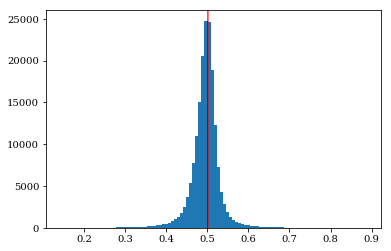

In [30]:
plt.hist(model_preds[3], bins=100)
plt.axvline(x=np.mean(model_preds[2]), color='red', lw=0.5)
plt.axvline(x=0.5, color='black', lw=0.5)
plt.show()

Plot number of recent matches histogram, grouped histogram & groups vs accuracy (for each model)
  
Correlations with the accuracy here would be due to both the quality of the data, and the uncertainty in the skill of players who are returning from long periods of inactivity.

In [104]:
meta[70000:, meta_labels.index("time_of_day")] / (60**2)

array([11.81938833, 10.18776639,  9.04110417, ..., 14.77132472,
       12.1445425 , 18.22075917])

In [31]:
rec_lens = sum([[len(X_rec_test[i][j]) for i in range(len(X_rec_test))] for j in N_PL_r], [])
rec_lens = np.asarray(rec_lens)

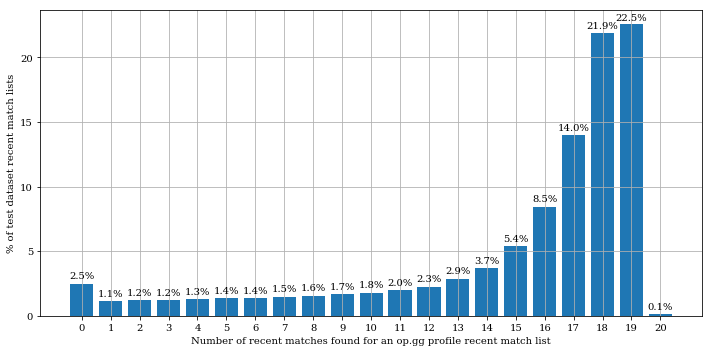

In [32]:
fig = plt.figure()
fig.set_size_inches(10, 5)
idx = [np.nonzero(rec_lens == n)[0] for n in range(21)]
totals = np.asarray([len(n_s) for n_s in idx])
rects1 = plt.bar(range(21), 100 * totals / (n_test * 10))
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        height = round(height, 1)
        plt.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
plt.xticks(range(21))
plt.xlabel("Number of recent matches found for an op.gg profile recent match list")
plt.ylabel("% of test dataset recent match lists")
plt.grid()
plt.tight_layout()
plt.savefig("graphs/recent_hist.pdf", filetype="pdf")
plt.show()

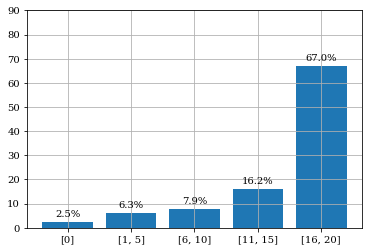

In [33]:
idx = [np.nonzero(rec_lens == n)[0] for n in range(21)]
totals = np.asarray([len(n_s) for n_s in idx])
# ranges = [[0], [1, 5], [6, 10], [11, 20]]
# ranges = [[0], [1, 3], [4, 6], [7, 9], [10, 12], [13, 15], [16, 20]]
# ranges = [[0], [1, 3], [4, 7], [8, 12], [13, 18], [19, 20]]
# ranges = [[0], [1, 4], [5, 8], [9, 12], [13, 16], [17, 20]]
# ranges = [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 15], [16, 20]]
# ranges = [[0], [1, 10], [11, 20]]
ranges = [[0], [1, 5], [6, 10], [11, 15], [16, 20]]
# ranges = [[i] for i in range(21)]
idx_sums = [sum([totals[i] for i in range(*((rng[0], rng[0] + 1) if len(rng) == 1 else (rng[0], rng[1] + 1)))]) for \
           rng in ranges]
rects1 = plt.bar(range(len(ranges)), 100 * np.asarray(idx_sums) / (n_test * 10))
plt.xticks(np.arange(len(ranges)), [str(rng) for rng in ranges])
plt.grid()
plt.ylim(0, 90)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        height = round(height, 1)
        plt.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
plt.show()

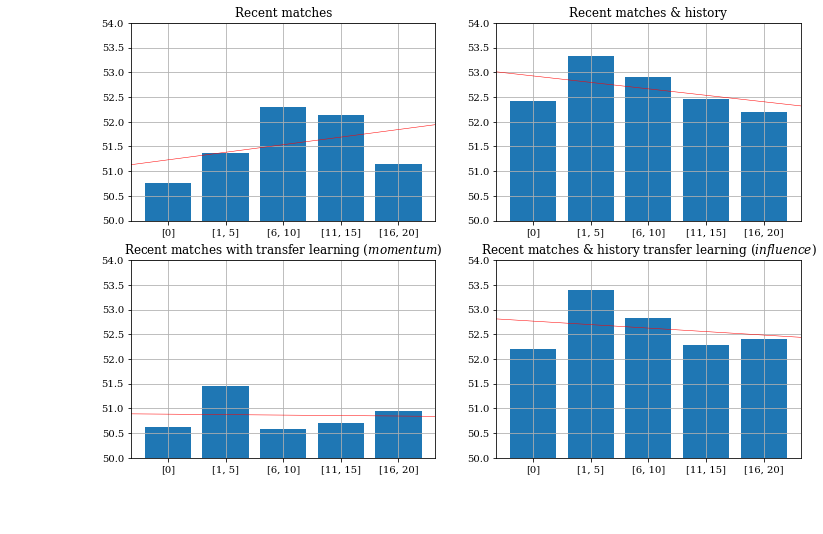

In [34]:
fig = plt.figure()
fig.set_size_inches(12, 8)
n_buckets = 3
rl1 = rec_max_len + 1
for m_i in range(len(models)):
    accs = []
    for rng in ranges:
        iz, iz_ = (rng[0], rng[0] + 1) if len(rng) == 1 else (rng[0], rng[1] + 1)
        idx_ = np.concatenate([idx[j] for j in range(iz, iz_)])
        accs.append(100 * np.mean(np.round(model_preds[m_i][idx_]) == Y_ambiwin[idx_]))
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
    plt.ylim(50, 54)
    x_ = np.arange(len(accs))
    g.bar(x_, accs)
    xlim, ylim = plt.xlim(), plt.ylim()
    g.plot([-5, +5], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-5], [+5]]), color='red', lw=0.5)
    plt.xlim(*xlim)
    plt.xticks(np.arange(len(accs)), [str(rng) for rng in ranges])
    g.set_title(list(models.keys())[m_i])
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            height = round(height, 1)
            plt.annotate('{}%'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects1)
# plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
plt.show()

Identify play sessions and streaks

In [35]:
# Options
session_cooldown = 2 * 60 * 60
min_pl_samples = 1
max_pl_samples = 3

In [36]:
pl_sessions = defaultdict(list)  # Account-id indexed list of tuples ( match idx, match session n, prior streak (+/-)
#   n full sessions, avg full session len, n full streaks (w/l/either), avg full streak size (w/l/either), n games )
session_match_n = defaultdict(list)  # Session solo/duo/flex queue match-n-indexed lists of indices into test set
prior_streak = defaultdict(list)  # Prior streak (positive (+) for win(s), negative (-) for loss(es))
session_match_n_idx = defaultdict(int)  # Session match ns of every index, for streak session continuation box plot
session_lens = defaultdict(int)  # Histogram count for full session lengths anywhere in test set
streak_lens = defaultdict(int)  # Histogram count for full streak lengths (+/-) anywhere in test set
tsm_ix = X_rec_labels.index("time_since_match")
win_ix = X_rec_labels.index("win")
dur_ix = X_rec_labels.index("duration")
pl_sls = OrderedDict([
    ("match_idx", 0),
    ("match_session_n", 1),
    ("prior_streak", 2),
    ("n_sessions", 3),
    ("avg_session_len", 4),
    ("n_win_streaks", 5),
    ("n_loss_streaks", 6),
    ("avg_streak_size", 7),
    ("avg_win_streak_size", 8),
    ("avg_loss_streak_size", 9),
    ("avg_streak_size", 10),
    ("n_games", 11),
    ("elo", 12),
    ("correct", 13),
    ("winrate", 14),
    ("n_session_games", 15),
    ("n_streak_games", 16),
])
for i in range(n_test):
    sys_print('\r' + str(i) + '/' + str(n_test) + '      ')
    for j in N_PL_r:
        if len(X_rec_test[i][j]) == 0: continue
        acc_id = meta[i, meta_labels.index("acc_ids__x" + str(j))]
        x_rec = X_rec_test[i][j]
        i_tst = (j * n_test) + i
        pl_session_lens = []
        pl_streaks = []
        pl_win_streaks = []
        pl_loss_streaks = []
        pl_outcomes = []
        match_session_n = 1  # Session match n of final target sample
        full_session_count = -2
        prev_t = np.inf
        t = 0
        last_outcome = 0
        streak_n = 0
        curr_streak = 0
        for k in range(len(x_rec) + 1):  # Iterate chronologically through recent match list
            t_end = x_rec[k, tsm_ix] if k < len(x_rec) else 0
            t_start = (t_end + x_rec[k, dur_ix]) if k < len(x_rec) else 0
            if prev_t - t_start > session_cooldown:  # New full session start detected
                if full_session_count >= 0:
                    pl_session_lens.append(match_session_n)  # Append length of previous full session
                    session_lens[match_session_n] += 1
                full_session_count += 1
                match_session_n = 1
            else:
                match_session_n += 1
            prev_t = t_end
            outcome = x_rec[k, win_ix] if k < len(x_rec) else Y_ambiwin[i_tst]
            outcome = int((outcome * 2) - 1)
            pl_outcomes.append(outcome)
            if k < 1:
                curr_streak = outcome
            else:
                if outcome != last_outcome:  # New full streak start detected
                    if streak_n >= 1:
                        if curr_streak > 0:
                            pl_win_streaks.append(curr_streak)  # Append length of previous streak
                            pl_streaks.append(curr_streak)
                            streak_lens[curr_streak] += 1
                        else:
                            pl_loss_streaks.append(-curr_streak)
                            pl_streaks.append(-curr_streak)
                            streak_lens[curr_streak] += 1
                    streak_n += 1
                    if k < len(x_rec):  # If this is the last iteration, do not update current streak (use prior)
                        curr_streak = outcome
                else:
                    if streak_n >= 1 and k < len(x_rec):  # Again, skip current streak update on last iteration (use prior)
                        curr_streak += 1 if curr_streak > 0 else -1
            last_outcome = outcome
        session_match_n[match_session_n].append(i_tst)
        session_match_n_idx[i_tst] = match_session_n
        prior_streak[curr_streak].append(i_tst)
        full_session_count = max(0, full_session_count)
        if len(pl_sessions[acc_id]) >= max_pl_samples:
            continue
        pl_sessions[acc_id].append((i_tst, match_session_n, curr_streak, full_session_count, 
            np.mean(pl_session_lens) if len(pl_session_lens) > 0 else 0,
            len(pl_streaks), len(pl_win_streaks), len(pl_loss_streaks),
            np.mean(pl_streaks) if len(pl_streaks) > 0 else 0,
            np.mean(pl_win_streaks) if len(pl_win_streaks) > 0 else 0,
            np.mean(pl_loss_streaks) if len(pl_loss_streaks) > 0 else 0,
            len(X_rec_test[i][j]),
            meta[(len(meta) - n_test) + i, meta_labels.index('elo')],
            Y_ambiwin[i_tst] == round(model_preds[2][i_tst]),
            np.mean(pl_outcomes),
            sum(pl_session_lens),
            sum(pl_win_streaks) + sum(pl_loss_streaks),
        ))
for acc_id in list(pl_sessions.keys()):
    if len(pl_sessions[acc_id]) < min_pl_samples:
        del pl_sessions[acc_id]

17742/17743      

Histogram of session length across entire test set

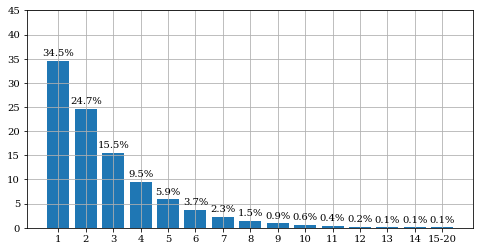

In [37]:
x, y = zip(*sorted(list(session_lens.items())))
x, y = list(x), list(y)
cap = 15
y[cap - 1] = sum(y[cap - 1:])
del x[cap:]
del y[cap:]
y = 100 * np.asarray(y) / sum(y)
fig = plt.figure()
fig.set_size_inches(8, 4)
rects1 = plt.bar(x, y)
plt.xticks(1 + np.arange(cap), [str(n) for n in range(1, cap)] + [str(cap) + '-20'])
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        height = round(height, 1)
        plt.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
autolabel(rects1)
plt.ylim(0, 45)
plt.grid()
plt.show()

Histograms of streak size across entire test set

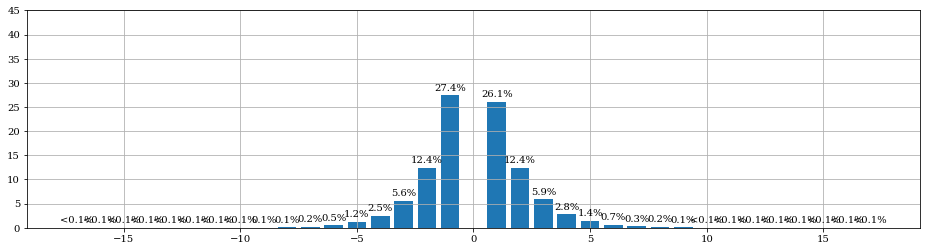

In [38]:
x, y = zip(*sorted(list(streak_lens.items())))
x, y = list(x), list(y)
# cap = 10
# y[cap - 1] = sum(y[cap - 1:])
# del x[cap:]
# del y[cap:]
y = 100 * np.asarray(y) / sum(y)
fig = plt.figure()
fig.set_size_inches(16, 4)
rects1 = plt.bar(x, y)
# plt.xticks(np.arange(len(x)), [str(n) for n in range(1, cap)] + [str(cap) + '+'])
# plt.xticks(1 + np.arange(cap), [str(n) for n in range(1, cap)] + [str(cap) + '+'])
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        height = round(height, 1)
        pc = '{}%'.format(height)
        if pc == '0.0%':
            pc = '<0.1%'
        plt.annotate(pc,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
autolabel(rects1)
plt.ylim(0, 45)
plt.grid()
plt.show()

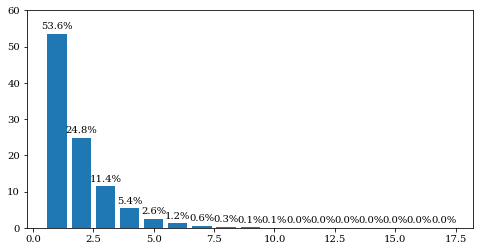

In [39]:
x, y = zip(*sorted(list(streak_lens.items())))
x, y = np.asarray(list(x)), np.asarray(list(y))
pos_ix = np.nonzero(x > 0)[0][0]
x, y = x[pos_ix:], y[pos_ix:] + y[:pos_ix][::-1]
# cap = 10
# y[cap - 1] = sum(y[cap - 1:])
# del x[cap:]
# del y[cap:]
y = 100 * y / sum(y)
fig = plt.figure()
fig.set_size_inches(8, 4)
rects1 = plt.bar(x, y)
plt.ylim(0, 60)
# plt.xticks(np.arange(len(x)), [str(n) for n in range(1, cap)] + [str(cap) + '+'])
# plt.xticks(1 + np.arange(cap), [str(n) for n in range(1, cap)] + [str(cap) + '+'])
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        height = round(height, 1)
        plt.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
autolabel(rects1)
# plt.grid()
plt.show()

Histogram of average length of a full session in the test set for a player

103056


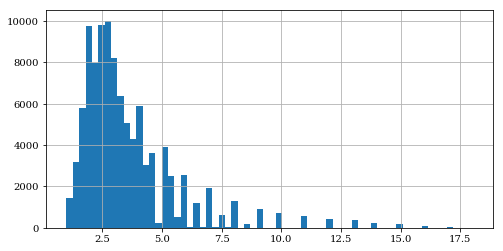

In [40]:
min_pl_n_sessions = 1
min_pl_n_games = 15
seen_pl = defaultdict(int)
d = [sum([s[4] * s[3] for s in sess]) / sum([s[3] for s in sess]) for sess in pl_sessions.values() if \
     sum([s[3] for s in sess]) >= min_pl_n_sessions and \
     sum([s[pl_sls["n_games"]] for s in sess]) >= min_pl_n_games]
print(len(d))
fig = plt.figure()
fig.set_size_inches(8, 4)
plt.hist(d, bins=64)
plt.grid()
plt.show()

Histogram of the number of full sessions in the test set for a player

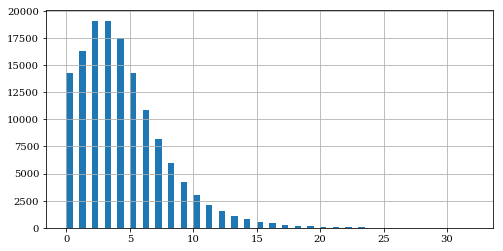

In [41]:
fig = plt.figure()
fig.set_size_inches(8, 4)
plt.hist([sum([s[3] for s in sess]) for sess in pl_sessions.values()], bins=64)
plt.grid()
plt.show()

Error bar plot and least squares fit of (w/l) streak size vs session match n of following game (if > 1)

This graph can be interpreted as the tendency of a player to continue a session given that they are on a win or loss streak, and how strong that tendency is compared to the size of the streak (the session match n of the game following the streak, given the signed streak length). Streaks continue between sessions.

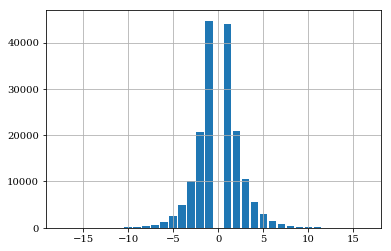

In [42]:
d = []
sorted_streaks, sorted_streak_ns = [list(x) for x in zip(*sorted(prior_streak.items()))]
plt.bar(sorted_streaks, [len(x) for x in sorted_streak_ns])
plt.grid()
plt.show()

In [43]:
streak_max_l = 15
session_match_n_min = 1
sorted_streaks = list(sorted_streaks)
sorted_streak_ns = list(sorted_streak_ns)
subset_is = list(range(sorted_streaks.index(-streak_max_l), sorted_streaks.index(streak_max_l) + 1))
sorted_streak_ns[subset_is[0]] += sum(sorted_streak_ns[:subset_is[0]], [])
sorted_streak_ns[subset_is[-1]] += sum(sorted_streak_ns[subset_is[-1] + 1:], [])
sorted_streaks, sorted_streak_ns = np.asarray(sorted_streaks)[subset_is], np.asarray(sorted_streak_ns)[subset_is]
for i in range(len(sorted_streaks)):
    idx = sorted_streak_ns[i]
    d.append([session_match_n_idx[ix] for ix in idx if session_match_n_idx[ix] >= session_match_n_min])
xs = np.arange(len(sorted_streaks))
xs[streak_max_l:] += 1
ys = [np.mean(d_) for d_ in d]
lens = [len(d_) for d_ in d]
stds = [np.var(d_) / 100 for d_ in d]

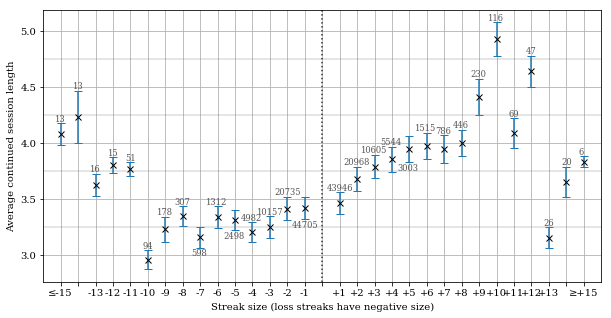

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
# plt.scatter(xs, ys)
mrks, _, _ = plt.errorbar(xs, ys, yerr=stds, fmt='x', capsize=4)
mrks.set_color('black')
# plt.ylim(3.4, 4.5)
xlim, ylim = plt.xlim(), plt.ylim()
# plt.plot([-50, 50], LinearRegression().fit(np.atleast_2d(xs).T, ys).predict([[-50], [+50]]), color='red', lw=0.5)
plt.xlim(*xlim)
plt.ylim(*ylim)
ls = [('+' if x > 0.5 else '') + str(x) for x in sorted_streaks]
ls[0] = '≤' + ls[0]
ls[-1] = '≥' + ls[-1]
ls[1] = ''
ls[-2] = ''
plt.xticks(np.arange(len(sorted_streaks) + 1), ls[:streak_max_l] + [''] + ls[streak_max_l:])
plt.xlim(-1, len(sorted_streaks) + 1)
plt.grid()
plt.axhline(y=4.25, color='grey', lw=0.4)
plt.axhline(y=3.75, color='grey', lw=0.4)
plt.axhline(y=3.25, color='grey', lw=0.4)
plt.axhline(y=4.75, color='grey', lw=0.4)
plt.axhline(y=5.25, color='grey', lw=0.4)
plt.axvline(x=15, color='#333333', ls=':')
for i in range(len(xs)):
    ax.annotate("" + str(lens[i]), (xs[i] - (0.31 if lens[i] < 100 else (0.5 if lens[i] < 1000 else (0.69 if lens[i] < 10000 else 0.76))),
                ys[i] + (((stds[i]) + 0.02) if i not in [5+3, 5+5, 5+9, 5+14, ] else -((stds[i]) + 0.07))),
               size='small', color="#555555")
plt.xlabel("Streak size (loss streaks have negative size)")
plt.ylabel("Average continued session length")
plt.savefig("graphs/cont_ses.pdf", filetype="pdf")
plt.show()
# fig, ax = plt.subplots()
# fig.set_size_inches(16, 10)
# ax.boxplot(d[:streak_max_l], whis=1.5, notch=True)
# plt.xticks(1 + np.arange(len(sorted_streaks[:streak_max_l])), [str(x) for x in sorted_streaks[:streak_max_l]])
# # plt.ylim(3.9, 4.1)
# plt.show()

Scatter plots and least squares fits between player average length of a session, win streak, and loss streak

In [45]:
# pl_sessions = defaultdict(list)  # Account-id indexed list of tuples ( match idx, match session n, prior streak (+/-)
#   n full sessions, avg full session len, n full streaks (w/l/either), avg full streak size (w/l/either) )
# 'full' means not a subset of a larger streak or session. we drop this label and assume by default in the pl_session_labels
acc_ids = list(pl_sessions.keys())
pl_ids = []
pl_elos = []
pl_accs = []
pl_winrates = []
pl_folded = []
for a_id in acc_ids:
    pl_d = np.asarray(pl_sessions[a_id])
    if len(pl_d) not in [2, 3]: continue
    if sum(pl_d[:, pl_sls["n_sessions"]]) < 1: continue
    if sum(pl_d[:, pl_sls["n_win_streaks"]]) < 1: continue
    if sum(pl_d[:, pl_sls["n_loss_streaks"]]) < 1: continue
#     if sum(pl_d[:, pl_sls["n_session_games"]]) not in range(10, 30): continue
    if sum(pl_d[:, pl_sls["n_session_games"]]) < 15: continue
    if sum(pl_d[:, pl_sls["n_streak_games"]]) < 15: continue

#     if sum(pl_d[:, pl_sls["n_games"]]) not in range(25, 35): continue
    pl_ids.append(a_id)
    pl_d_n_sessions = pl_d[:, pl_sls["n_sessions"]]
    session_len_avg = np.sum(pl_d[:, pl_sls["avg_session_len"]] * pl_d_n_sessions) / np.sum(pl_d_n_sessions)
    pl_d_n_wstreaks = pl_d[:, pl_sls["n_win_streaks"]]
    wstreak_size_avg = np.sum(pl_d[:, pl_sls["avg_win_streak_size"]] * pl_d_n_wstreaks) / np.sum(pl_d_n_wstreaks)
    pl_d_n_lstreaks = pl_d[:, pl_sls["n_loss_streaks"]]
    lstreak_size_avg = np.sum(pl_d[:, pl_sls["avg_loss_streak_size"]] * pl_d_n_lstreaks) / np.sum(pl_d_n_lstreaks)
    pl_d_n_estreaks = pl_d[:, pl_sls["n_win_streaks"]] + pl_d[:, pl_sls["n_loss_streaks"]]
    estreak_size_avg = (np.sum(pl_d[:, pl_sls["avg_win_streak_size"]] * pl_d_n_wstreaks) + \
                        np.sum(pl_d[:, pl_sls["avg_loss_streak_size"]] * pl_d_n_lstreaks)) / np.sum(pl_d_n_estreaks)
    winrate = np.mean(pl_d[:, pl_sls["winrate"]])
    elos = np.mean(pl_d[:, pl_sls["elo"]])
    pl_folded.append([session_len_avg, wstreak_size_avg, lstreak_size_avg, estreak_size_avg, elos, winrate])
    pl_elos.append(elos)
    pl_accs.append(np.mean(pl_d[:, pl_sls["correct"]]))
    pl_winrates.append(winrate)
pl_folded = np.asarray(pl_folded)
pl_elos_normd = pl_elos - min(pl_elos)
pl_elos_normd /= max(pl_elos_normd)
min(pl_elos_normd), max(pl_elos_normd)
pl_folded.shape

(15807, 6)

In [46]:
lr_x = [[-50], [+50]]
yz = [TheilSenRegressor().fit(np.atleast_2d(pl_folded[:, 0]).T, pl_folded[:, 1]).predict(lr_x) for _ in range(10)]
lr_y = np.mean(yz, axis=0)
gradient = (lr_y[1] - lr_y[0]) / (lr_x[1][0] - lr_x[0][0])
print(gradient, np.mean(pl_folded[:, 1]))

0.011393985890088061 1.9310549673464763


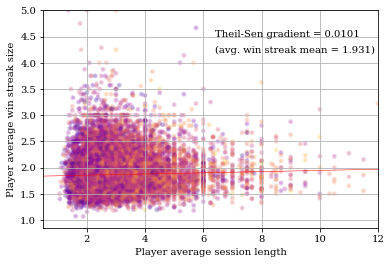

In [49]:
fig = plt.figure()
fig.set_size_inches(6, 4)
n_draw = pl_folded.shape[0]
plt.scatter(pl_folded[:n_draw, 0], pl_folded[:n_draw, 1], marker='.', lw=2, alpha=0.2,
            c=pl_elos[:n_draw], cmap=plt.get_cmap('plasma'))
xlim, ylim = plt.xlim(), plt.ylim()
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.plot(np.asarray(lr_x).flatten(), lr_y, color='red', lw=0.5)
plt.xlabel("Player average session length")
plt.ylabel("Player average win streak size")
plt.grid()
plt.ylim(0.85, 5)
plt.xlim(0.5, 12)
plt.text(6.4, 4.5, "Theil-Sen gradient = 0.0101")
plt.text(6.4, 4.2, "(avg. win streak mean = 1.931)")
plt.savefig("graphs/wstreak_grad.pdf", filetype="pdf")
plt.show()

In [50]:
lr_x = [[-50], [+50]]
yz = [TheilSenRegressor().fit(np.atleast_2d(pl_folded[:, 0]).T, pl_folded[:, 2]).predict(lr_x) for _ in range(10)]
lr_y_ = np.mean(yz, axis=0)
gradient_ = (lr_y_[1] - lr_y_[0]) / (lr_x[1][0] - lr_x[0][0])
print(gradient_, np.mean(pl_folded[:, 2]))

0.04215810633570061 1.9679774043727263


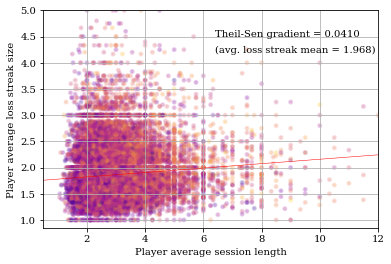

In [51]:
fig = plt.figure()
fig.set_size_inches(6, 4)
n_draw = pl_folded.shape[0]
plt.scatter(pl_folded[:n_draw, 0], pl_folded[:n_draw, 2], marker='.', lw=2, alpha=0.2,
            c=pl_elos[:n_draw], cmap=plt.get_cmap('plasma'))
xlim, ylim = plt.xlim(), plt.ylim()
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.plot(np.asarray(lr_x).flatten(), lr_y_, color='red', lw=0.5)
plt.xlabel("Player average session length")
plt.ylabel("Player average loss streak size")
plt.grid()
plt.ylim(0.85, 5)
plt.xlim(0.5, 12)
plt.text(6.4, 4.5, "Theil-Sen gradient = 0.0410")
plt.text(6.4, 4.2, "(avg. loss streak mean = 1.968)")
plt.savefig("graphs/lstreak_grad.pdf", filetype="pdf")
plt.show()

This one shows the effect of smurfs/boosting when ```min_pl_n_sessions``` is too small. Todo: get accuracy for samples that belong to each quadrant of the aligned blob, corresponding to the following categories:
1. High swing factor, chases losses more -> Addict
2. High swing factor, plays momentum more -> Baller
3. Low swing factor, chases losses more -> Tilter
2. Low swing factor, plays momentum more -> Healthy

1.0096192054691842


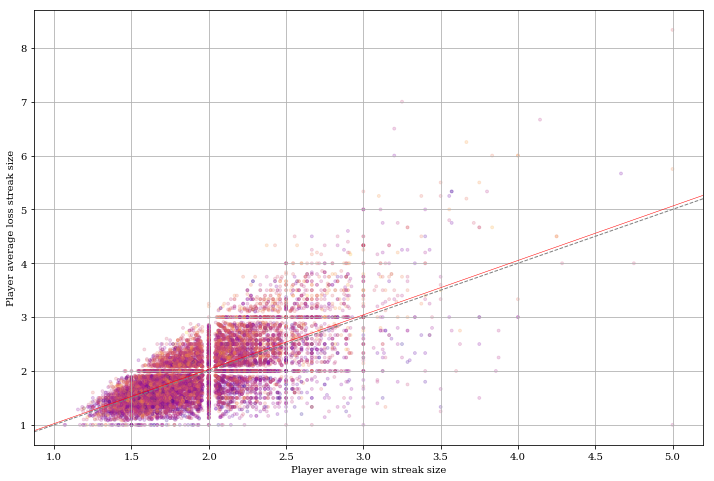

In [52]:
fig = plt.figure()
fig.set_size_inches(12, 8)
plt.scatter(pl_folded[:, 1], pl_folded[:, 2], marker='.', lw=0.8, alpha=0.2, c=pl_elos, cmap=plt.get_cmap('plasma'))
lr_x = [[-50], [+50]]
lr_y = TheilSenRegressor().fit(np.atleast_2d(pl_folded[:, 1]).T, pl_folded[:, 2]).predict(lr_x)
print((lr_y[1] - lr_y[0]) /(lr_x[1][0] - lr_x[0][0]))
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot(np.asarray(lr_x).flatten(), lr_y, color='red', lw=0.5)
plt.plot([-50, +50], [-50, +50], color="grey", lw=1.0, ls='--')
plt.xlim(*xlim)
plt.ylim(*ylim)
# plt.axis('equal')
# plt.xlim(0.5, 9)
# plt.ylim(0.5, 16)
plt.xlabel("Player average win streak size")
plt.ylabel("Player average loss streak size")
plt.grid()
plt.show()

Accuracy vs session & streak lengths. First make histograms & define buckets

0.5084025713360436


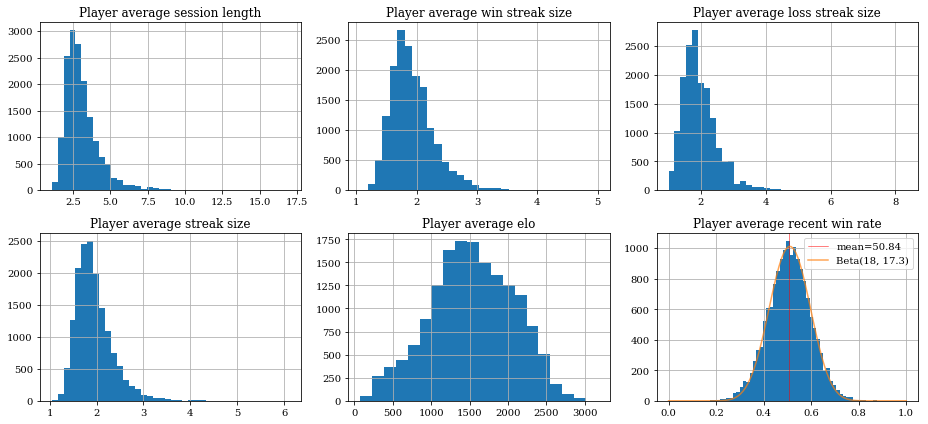

In [53]:
n_init_buckets = 40
fig = plt.figure()
fig.set_size_inches(13, 6)
g = fig.add_subplot(2, 3, 1)
g.grid()
g.set_title("Player average session length")
n_s, buckets_s, _ = g.hist(pl_folded[:, 0], bins=n_init_buckets)
g = fig.add_subplot(2, 3, 2)
g.grid()
g.set_title("Player average win streak size")
n_w, buckets_w, _ = g.hist(pl_folded[:, 1], bins=n_init_buckets - 8) # Otherwise we get too many buckets!
g = fig.add_subplot(2, 3, 3)
g.grid()
g.set_title("Player average loss streak size")
n_l, buckets_l, _ = g.hist(pl_folded[:, 2], bins=n_init_buckets)
g = fig.add_subplot(2, 3, 4)
g.grid()
g.set_title("Player average streak size")
n_e, buckets_e, _ = g.hist(pl_folded[:, 3], bins=n_init_buckets)
g = fig.add_subplot(2, 3, 5)
g.grid()
g.set_title("Player average elo")
n_elo, buckets_elo, _ = g.hist(pl_folded[:, 4], bins=20)
g = fig.add_subplot(2, 3, 6)
g.grid()
g.set_title("Player average recent win rate")
pl_wr = (pl_folded[:, 5] / 2) + 0.5
n_wr, buckets_wr, _ = g.hist(pl_wr, bins=50)
wr_mean = np.mean(pl_wr)
print(wr_mean)
g.axvline(x=wr_mean, color='red', lw=0.5, label="mean=50.84")
g.plot(np.linspace(0, 1, 100), scipy.stats.beta.pdf(np.linspace(0, 1, 100), 18, 17.3) * 215, alpha=0.7, label="Beta(18, 17.3)")
g.legend()
# g.plot(np.linspace(0, 1, 100), scipy.stats.beta.pdf(np.linspace(0, 1, 100), 17.7, 17.7) * 215, alpha=1)
# g = fig.add_subplot(2, 4, 6)
# g.grid()
# g.set_title("Player winrate")
# n_e, buckets_e, _ = g.hist(pl_wr, bins=50)
# g.plot(np.linspace(0, 1, 100), scipy.stats.beta.pdf(np.linspace(0, 1, 100), 18, 17.3) * 215, alpha=1)
plt.tight_layout()
plt.savefig("graphs/player_averages_hist.pdf", filetype="pdf")
plt.show()

In [54]:
# Define trimmed buckets
min_bucket_n = 100
flip = False
trim_left, trim_right = [], []
for i in range(len(n_s)):
    if n_s[i] < min_bucket_n:
        if flip: trim_right.append(i)
        else:    trim_left.append(i)
    else:
        flip = True
if trim_left == []: trim_left = [-1]
buckets_s[trim_left[-1] + 1] = buckets_s[0]  # Set the left edge of the first non-trimmed bucket to the first left edge
buckets_s[trim_right[0]] = buckets_s[-1]     # Set the right edge of the last non-trimmed bucket to the final right edge
buckets_s = buckets_s[trim_left[-1] + 1:trim_right[0] + 1]  # Do the trimming
s_N = len(buckets_s) - 1
flip = False
trim_left, trim_right = [], []
for i in range(len(n_w)):
    if n_w[i] < min_bucket_n:
        if flip: trim_right.append(i)
        else:    trim_left.append(i)
    else:
        flip = True
if trim_left == []: trim_left = [-1]
buckets_w[trim_left[-1] + 1] = buckets_w[0]  # Set the left edge of the first non-trimmed bucket to the first left edge
buckets_w[trim_right[0]] = buckets_w[-1]     # Set the right edge of the last non-trimmed bucket to the final right edge
buckets_w = buckets_w[trim_left[-1] + 1:trim_right[0] + 1]  # Do the trimming
w_N = len(buckets_w) - 1
flip = False
trim_left, trim_right = [], []
for i in range(len(n_l)):
    if n_l[i] < min_bucket_n:
        if flip: trim_right.append(i)
        else:    trim_left.append(i)
    else:
        flip = True
if trim_left == []: trim_left = [-1]
buckets_l[trim_left[-1] + 1] = buckets_l[0]  # Set the left edge of the first non-trimmed bucket to the first left edge
buckets_l[trim_right[0]] = buckets_l[-1]     # Set the right edge of the last non-trimmed bucket to the final right edge
buckets_l = buckets_l[trim_left[-1] + 1:trim_right[0] + 1]  # Do the trimming
l_N = len(buckets_l) - 1
flip = False
trim_left, trim_right = [], []
for i in range(len(n_e)):
    if n_e[i] < min_bucket_n:
        if flip: trim_right.append(i)
        else:    trim_left.append(i)
    else:
        flip = True
if trim_left == []: trim_left = [-1]
buckets_e[trim_left[-1] + 1] = buckets_e[0]  # Set the left edge of the first non-trimmed bucket to the first left edge
buckets_e[trim_right[0]] = buckets_e[-1]     # Set the right edge of the last non-trimmed bucket to the final right edge
buckets_e = buckets_e[trim_left[-1] + 1:trim_right[0] + 1]  # Do the trimming
e_N = len(buckets_e) - 1
flip = False
trim_left, trim_right = [], []
for i in range(len(n_elo)):
    if n_elo[i] < 500:
        if flip: trim_right.append(i)
        else:    trim_left.append(i)
    else:
        flip = True
if trim_left == []: trim_left = [-1]
buckets_elo[trim_left[-1] + 1] = buckets_elo[0]  # Set the left edge of the first non-trimmed bucket to the first left edge
buckets_elo[trim_right[0]] = buckets_elo[-1]     # Set the right edge of the last non-trimmed bucket to the final right edge
buckets_elo = buckets_elo[trim_left[-1] + 1:trim_right[0] + 1]  # Do the trimming
elo_N = len(buckets_elo) - 1

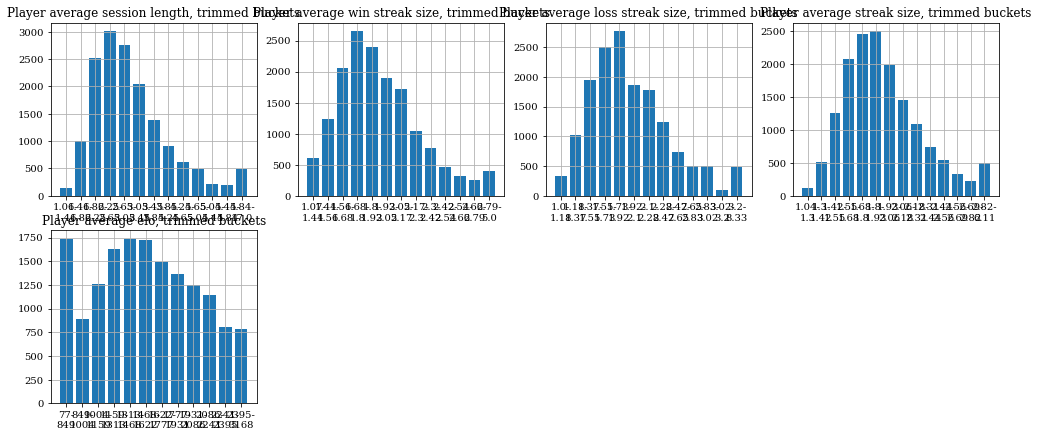

In [55]:
fig = plt.figure()
fig.set_size_inches(17, 7)
g = fig.add_subplot(2, 4, 1)
g.grid()
g.set_title("Player average session length, trimmed buckets")
s_count = [np.sum(np.logical_and(pl_folded[:, 0] >= buckets_s[i], pl_folded[:, 0] < buckets_s[i + 1])) for \
                        i in range(s_N)]
g.bar(np.arange(s_N), s_count)
s_bucket_labels = [str(round(buckets_s[i], 2)) + '-\n' + str(round(buckets_s[i + 1], 2)) for i in range(s_N)]
plt.xticks(np.arange(s_N), s_bucket_labels)
g = fig.add_subplot(2, 4, 2)
g.grid()
g.set_title("Player average win streak size, trimmed buckets")
w_count = [np.sum(np.logical_and(pl_folded[:, 1] >= buckets_w[i], pl_folded[:, 1] < buckets_w[i + 1])) for \
                        i in range(w_N)]
g.bar(np.arange(w_N), w_count)
w_bucket_labels = [str(round(buckets_w[i], 2)) + '-\n' + str(round(buckets_w[i + 1], 2)) for i in range(w_N)]
plt.xticks(np.arange(w_N), w_bucket_labels)
g = fig.add_subplot(2, 4, 3)
g.grid()
g.set_title("Player average loss streak size, trimmed buckets")
l_count = [np.sum(np.logical_and(pl_folded[:, 2] >= buckets_l[i], pl_folded[:, 2] < buckets_l[i + 1])) for \
                        i in range(l_N)]
g.bar(np.arange(l_N), l_count)
l_bucket_labels = [str(round(buckets_l[i], 2)) + '-\n' + str(round(buckets_l[i + 1], 2)) for i in range(l_N)]
plt.xticks(np.arange(l_N), l_bucket_labels)
g = fig.add_subplot(2, 4, 4)
g.grid()
g.set_title("Player average streak size, trimmed buckets")
e_count = [np.sum(np.logical_and(pl_folded[:, 3] >= buckets_e[i], pl_folded[:, 3] < buckets_e[i + 1])) for \
                        i in range(e_N)]
g.bar(np.arange(e_N), e_count)
e_bucket_labels = [str(round(buckets_e[i], 2)) + '-\n' + str(round(buckets_e[i + 1], 2)) for i in range(e_N)]
plt.xticks(np.arange(e_N), e_bucket_labels)
g = fig.add_subplot(2, 4, 5)
g.grid()
g.set_title("Player average elo, trimmed buckets")
elo_counts = [np.sum(np.logical_and(pl_folded[:, 4] >= buckets_elo[i], pl_folded[:, 4] < buckets_elo[i + 1])) for \
                        i in range(elo_N)]
g.bar(np.arange(elo_N), elo_counts)
elo_bucket_labels = [str(int(round(buckets_elo[i]))) + '-\n' + str(int(round(buckets_elo[i + 1]))) for i in range(elo_N)]
plt.xticks(np.arange(elo_N), elo_bucket_labels)
plt.show()

In [56]:
pl_ids = np.asarray(pl_ids)
model_accs_s = []
for i in range(len(buckets_s) - 1):
    players = pl_ids[np.nonzero(np.logical_and(pl_folded[:, 0] >= buckets_s[i], pl_folded[:, 0] < buckets_s[i + 1]))[0]]
    idx = sum([[s[0] for s in pl_sessions[pl_id]] for pl_id in players], [])
    model_accs_s.append([100 * np.mean(np.round(model_preds[m_i][idx]) == Y_ambiwin[idx]) for m_i in range(len(models))])
model_accs_s = np.asarray(model_accs_s)
model_accs_w = []
for i in range(len(buckets_w) - 1):
    players = pl_ids[np.nonzero(np.logical_and(pl_folded[:, 1] >= buckets_w[i], pl_folded[:, 1] < buckets_w[i + 1]))[0]]
    idx = sum([[s[0] for s in pl_sessions[pl_id]] for pl_id in players], [])
    model_accs_w.append([100 * np.mean(np.round(model_preds[m_i][idx]) == Y_ambiwin[idx]) for m_i in range(len(models))])
model_accs_w = np.asarray(model_accs_w)
model_accs_l = []
for i in range(len(buckets_l) - 1):
    players = pl_ids[np.nonzero(np.logical_and(pl_folded[:, 2] >= buckets_l[i], pl_folded[:, 2] < buckets_l[i + 1]))[0]]
    idx = sum([[s[0] for s in pl_sessions[pl_id]] for pl_id in players], [])
    model_accs_l.append([100 * np.mean(np.round(model_preds[m_i][idx]) == Y_ambiwin[idx]) for m_i in range(len(models))])
model_accs_l = np.asarray(model_accs_l)
model_accs_e = []
for i in range(len(buckets_e) - 1):
    players = pl_ids[np.nonzero(np.logical_and(pl_folded[:, 3] >= buckets_e[i], pl_folded[:, 3] < buckets_e[i + 1]))[0]]
    idx = sum([[s[0] for s in pl_sessions[pl_id]] for pl_id in players], [])
    model_accs_e.append([100 * np.mean(np.round(model_preds[m_i][idx]) == Y_ambiwin[idx]) for m_i in range(len(models))])
model_accs_e = np.asarray(model_accs_e)
model_probs_elo = []
model_probs_elo_median = []
for i in range(len(buckets_elo) - 1):
    players = pl_ids[np.nonzero(np.logical_and(pl_folded[:, 4] >= buckets_elo[i], pl_folded[:, 4] < buckets_elo[i + 1]))[0]]
    idx = sum([[s[0] for s in pl_sessions[pl_id]] for pl_id in players], [])
    model_probs_elo.append([100 * np.mean(model_preds[m_i][idx]) for m_i in range(len(models))])
    model_probs_elo_median.append([100 * np.median(model_preds[m_i][idx]) for m_i in range(len(models))])
model_probs_elo = np.asarray(model_probs_elo)
model_probs_elo_median = np.asarray(model_probs_elo_median)

In [57]:
def autolabel(rects, txts):
    i = -1
    for rect in rects:
        i += 1
        height = rect.get_height()
        height = round(height, 1)
        plt.annotate(txts[i],
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color="#333333")

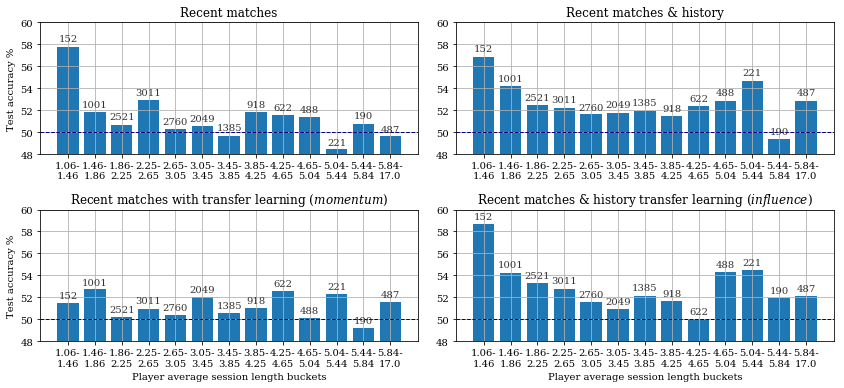

In [58]:
fig = plt.figure()
fig.set_size_inches(12, 5.5)
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
#     plt.ylim(45.0,  57.0)
#     plt.xlim(-0.75,  4.75)
    x_ = np.arange(s_N)
    accs = model_accs_s[:, m_i]
    rects1 = g.bar(x_, accs)
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.xlim(*xlim)
    plt.ylim(48, 60)
#     g.plot([-50, +50], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-50], [+50]]), color='red', lw=0.5)
    plt.xticks(x_, s_bucket_labels)
    g.set_title(list(models.keys())[m_i])
    g.axhline(y=50, color='darkblue', lw='1.0', ls='--')
    autolabel(rects1, s_count)
    if m_i >= 2: plt.xlabel("Player average session length buckets")
    if m_i % 2 == 0: plt.ylabel("Test accuracy %")
fig.tight_layout()
plt.savefig(graphs_folder + '/sessl_acc.pdf', format='pdf')
plt.show()

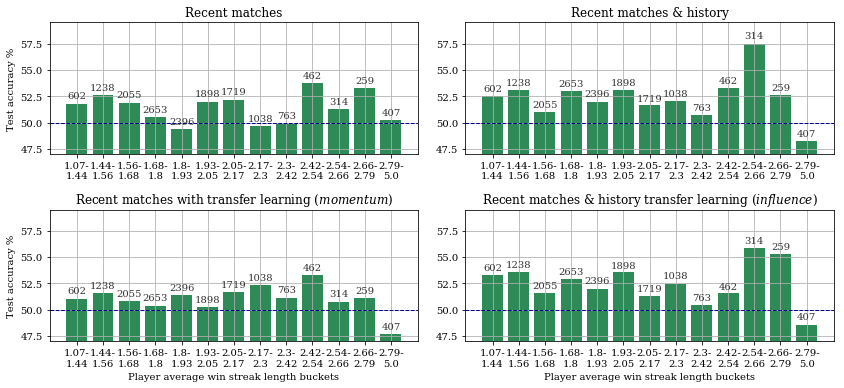

In [59]:
fig = plt.figure()
fig.set_size_inches(12, 5.5)
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
#     plt.ylim(45.0,  57.0)
#     plt.xlim(-0.75,  4.75)
    x_ = np.arange(w_N)
    accs = model_accs_w[:, m_i]
    rects1 = g.bar(x_, accs, color="seagreen")
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.xlim(*xlim)
    plt.ylim(47, 59.5)
#     g.plot([-50, +50], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-50], [+50]]), color='red', lw=0.5)
    plt.xticks(x_, w_bucket_labels)
    g.set_title(list(models.keys())[m_i])
    g.axhline(y=50, color='darkblue', lw='1.0', ls='--')
    autolabel(rects1, w_count)
    if m_i >= 2: plt.xlabel("Player average win streak length buckets")
    if m_i % 2 == 0: plt.ylabel("Test accuracy %")
fig.tight_layout()
plt.savefig(graphs_folder + '/wstreak_acc.pdf', format='pdf')
plt.show()

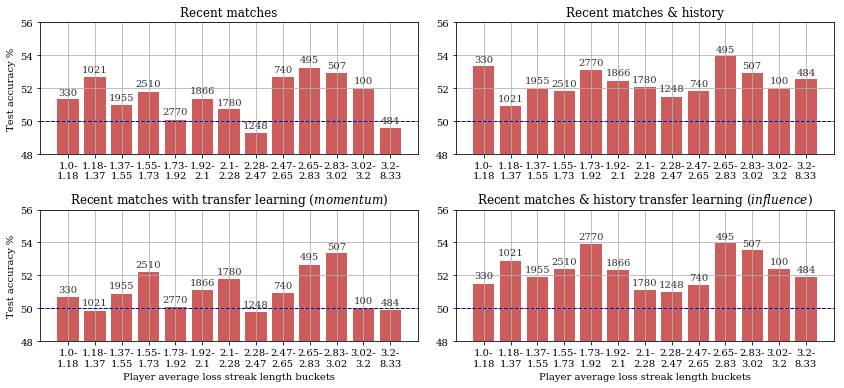

In [60]:
fig = plt.figure()
fig.set_size_inches(12, 5.5)
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
#     plt.ylim(45.0,  57.0)
#     plt.xlim(-0.75,  4.75)
    x_ = np.arange(l_N)
    accs = model_accs_l[:, m_i]
    rects1 = g.bar(x_, accs, color="indianred")
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.xlim(*xlim)
    plt.ylim(48, 56)
#     g.plot([-50, +50], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-50], [+50]]), color='red', lw=0.5)
    plt.xticks(x_, l_bucket_labels)
    g.set_title(list(models.keys())[m_i])
    g.axhline(y=50, color='darkblue', lw='1.0', ls='--')
    autolabel(rects1, l_count)
    if m_i >= 2: plt.xlabel("Player average loss streak length buckets")
    if m_i % 2 == 0: plt.ylabel("Test accuracy %")
fig.tight_layout()
plt.savefig(graphs_folder + '/lstreak_acc.pdf', format='pdf')
plt.show()

In [1]:
fig = plt.figure()
fig.set_size_inches(12, 5.5)
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
#     plt.ylim(45.0,  57.0)
#     plt.xlim(-0.75,  4.75)
    x_ = np.arange(e_N)
    accs = model_accs_e[:, m_i]
    rects1 = g.bar(x_-0.22, accs, width=0.44, color="blue", alpha=0.2)
    if m_i == 0:
        rects1 = g.bar(x_+0.22, model_accs_e[:, m_i + 2], width=0.44, color="blueviolet")
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.xlim(*xlim)
    plt.ylim(48, 56.5)
#     g.plot([-50, +50], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-50], [+50]]), color='red', lw=0.5)
    plt.xticks(x_, e_bucket_labels)
#     g.set_title(list(models.keys())[m_i])
    g.set_title("Effect of transfer learning on recent matches (momentum) model")
    g.axhline(y=50, color='darkblue', lw='1.0', ls='--')
    autolabel(rects1, e_count)
#     if m_i >= 2: plt.xlabel("Player average streak length buckets")
    plt.xlabel("Player average streak length buckets")
    if m_i % 2 == 0: plt.ylabel("Test accuracy %")
fig.tight_layout()
plt.savefig(graphs_folder + '/streak_acc_paper.pdf', format='pdf')
plt.show()

NameError: name 'plt' is not defined

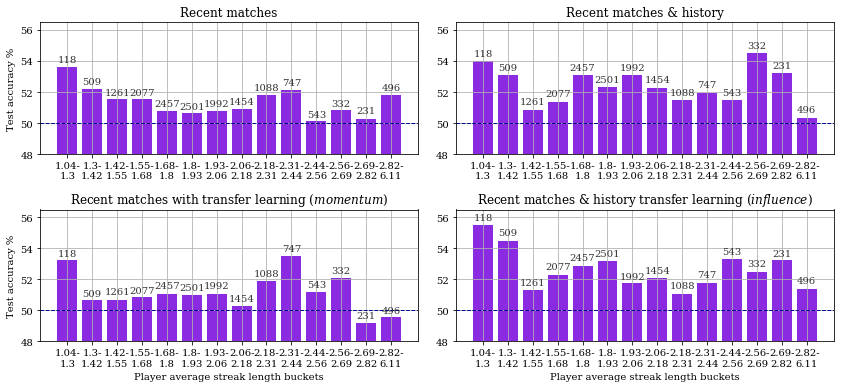

In [117]:
fig = plt.figure()
fig.set_size_inches(12, 5.5)
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
#     plt.ylim(45.0,  57.0)
#     plt.xlim(-0.75,  4.75)
    x_ = np.arange(e_N)
    accs = model_accs_e[:, m_i]
    rects1 = g.bar(x_, accs, color="blueviolet")
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.xlim(*xlim)
    plt.ylim(48, 56.5)
#     g.plot([-50, +50], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-50], [+50]]), color='red', lw=0.5)
    plt.xticks(x_, e_bucket_labels)
    g.set_title(list(models.keys())[m_i])
    g.axhline(y=50, color='darkblue', lw='1.0', ls='--')
    autolabel(rects1, e_count)
    if m_i >= 2: plt.xlabel("Player average streak length buckets")
    if m_i % 2 == 0: plt.ylabel("Test accuracy %")
fig.tight_layout()
plt.savefig(graphs_folder + '/streak_acc.pdf', format='pdf')
plt.show()

In [64]:
X_rec_labels.index("time_since_match")

80

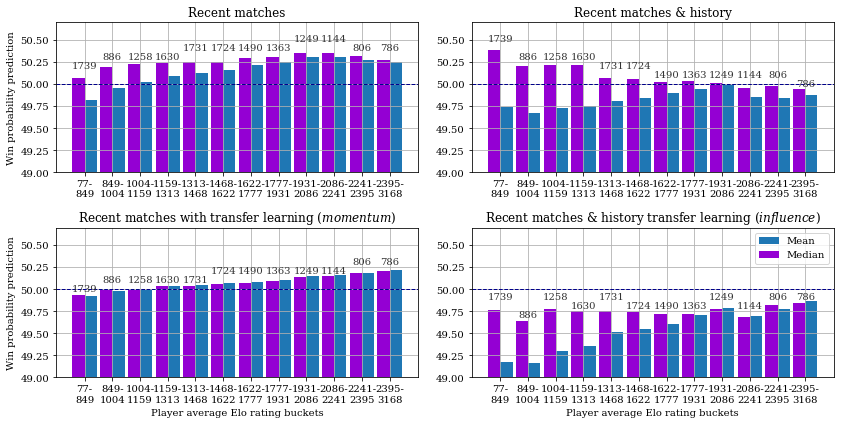

In [62]:
def autolabel_r(rects, txts):
    i = -1
    for rect in rects:
        i += 1
        height = rect.get_height()
        height = round(height, 1)
        plt.annotate(txts[i],
                    xy=(rect.get_x() + rect.get_width(), height+0.025),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color="#333333")
fig = plt.figure()
fig.set_size_inches(12, 6)
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
#     plt.ylim(45.0,  57.0)
#     plt.xlim(-0.75,  4.75)
    x_ = np.arange(elo_N)
    accs = model_probs_elo[:, m_i]
    g.bar(x_+0.22, accs, width=0.44, label="Mean")
    rects1 = g.bar(x_-0.22, model_probs_elo_median[:, m_i], width=0.44, color="darkviolet", label="Median")
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.xlim(*xlim)
    plt.ylim(49, 50.7)
#     g.plot([-50, +50], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-50], [+50]]), color='red', lw=0.5)
    plt.xticks(x_, elo_bucket_labels)
    g.set_title(list(models.keys())[m_i])
    g.axhline(y=50, color='darkblue', lw='1.0', ls='--')
    autolabel_r(rects1, elo_counts)
    if m_i >= 2: plt.xlabel("Player average Elo rating buckets")
    if m_i % 2 == 0: plt.ylabel("Win probability prediction")
    if m_i == 3:
        g.legend()
fig.tight_layout()
plt.savefig(graphs_folder + '/elo_winp.pdf', format='pdf')
plt.show()

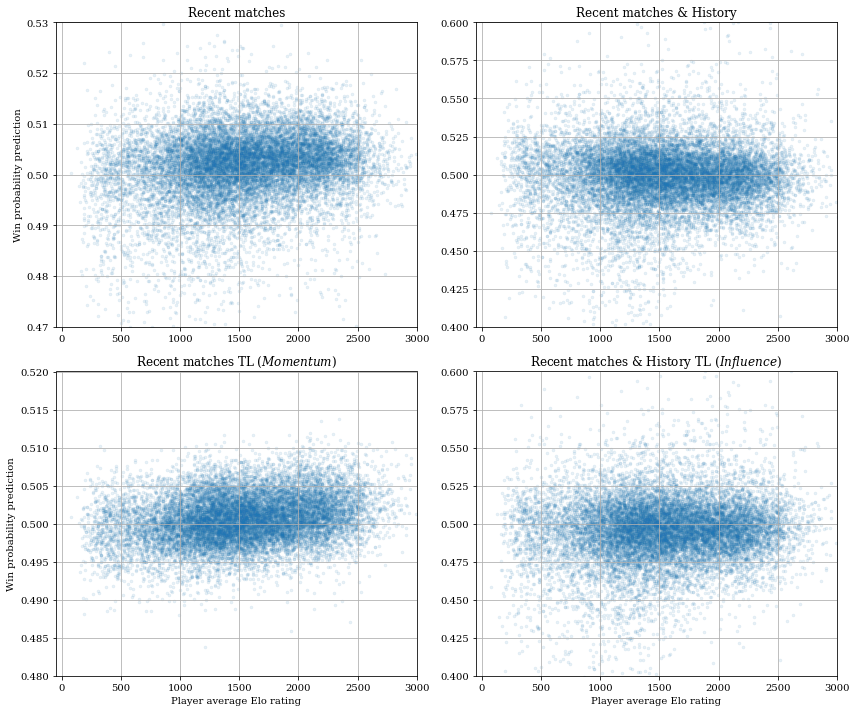

In [642]:
fig = plt.figure()
fig.set_size_inches(12, 10)
xs_elosc = []
ys_elosc = []
for i, pl_id in enumerate(pl_ids):
    xs_elosc.append( pl_elos[i] )
    ys_elosc.append( [s[0] for s in pl_sessions[pl_id]] )
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
#     lr_x_elo = [[0], [4000]]
#     yz_elo = [Ridge().fit(np.atleast_2d(pliz[:n__, 1]).T, model_preds[m_i][pliz[:n__, 0].astype(int)]).predict(lr_x_elo) for _ in range(10)]
#     lr_y_elo = np.mean(yz_elo, axis=0)
#     gradient_ = (lr_y_[1] - lr_y_[0]) / (lr_x[1][0] - lr_x[0][0])
#     print(gradient_, np.mean(pl_folded[:, 2]))
    ys_val = [np.mean([model_preds[m_i][v_] for v_ in v]) for v in ys_elosc]
    g.scatter(xs_elosc, ys_val, marker='.', lw=0.5, alpha=0.1)
#     g.plot(lr_x_elo, lr_y_elo, color='red', lw=0.5)
    g.grid()
    g.set_title(list(models.keys())[m_i])
    plt.ylim(0.4, 0.6)
    plt.xlim(-50, 3000)
    if m_i >= 2: plt.xlabel("Player average Elo rating")
    if m_i % 2 == 0: plt.ylabel("Win probability prediction")
    if m_i == 0: plt.ylim(0.47, 0.53)
    if m_i == 2: plt.ylim(0.48, 0.52)
#     if m_i == 3:
#         g.legend()
plt.tight_layout()
plt.savefig(graphs_folder + '/elo_scatter.pdf', format='pdf')
plt.show()

Accuracy vs session match n & prior streak (histograms first, though these are less useful versions of the earlier session/streak length histograms)

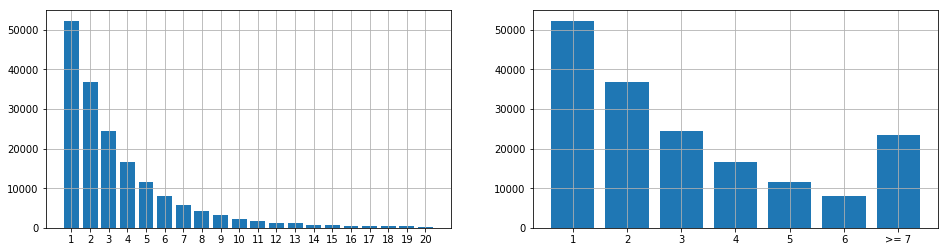

In [489]:
session_match_n_lim = 7
fig = plt.figure()
fig.set_size_inches(16, 4)
session_match_ls = sorted(list(session_match_n.keys()))
session_match_counts = np.asarray([len(session_match_n[l]) for l in session_match_ls])
g = fig.add_subplot(1, 2, 1)
g.grid()
g.bar(np.arange(len(session_match_ls)), session_match_counts)
plt.xticks(np.arange(len(session_match_ls)), session_match_ls)
session_match_n_grp = deepcopy([session_match_n[l] for l in session_match_ls if l <= session_match_n_lim])
session_match_n_grp[-1] += sum([session_match_n[l] for l in session_match_ls if l > session_match_n_lim], [])
session_match_ls_ = [l for l in session_match_ls if l < session_match_n_lim] + ['>= ' + str(session_match_n_lim)]
session_match_counts_ = np.asarray([len(session_match_n_grp[i]) for i in range(len(session_match_n_grp))])
g = fig.add_subplot(1, 2, 2)
g.grid()
g.bar(np.arange(len(session_match_ls_)), session_match_counts_)
plt.xticks(np.arange(len(session_match_ls_)), session_match_ls_)
plt.show()

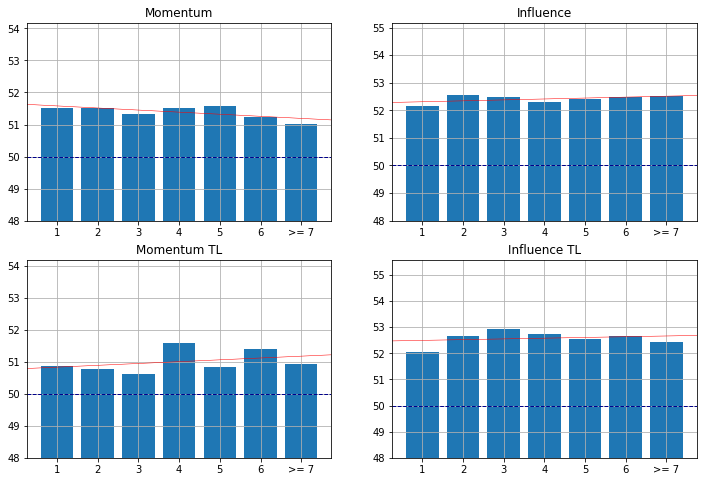

In [490]:
fig = plt.figure()
fig.set_size_inches(12, 8)
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
#     plt.ylim(45.0,  57.0)
#     plt.xlim(-0.75,  4.75)
    x_ = np.arange(len(session_match_n_grp))
    accs = []
    for i in range(len(session_match_n_grp)):
        idx = session_match_n_grp[i]
        accs.append(100 * np.mean(np.round(model_preds[m_i][idx]) == Y_ambiwin[idx]))
    accs = np.asarray(accs)
    g.bar(x_, accs)
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.xlim(*xlim)
    plt.ylim(48, ylim[1])
    g.plot([-50, +50], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-50], [+50]]), color='red', lw=0.5)
    plt.xticks(x_, session_match_ls_)
    g.set_title(list(models.keys())[m_i])
    g.axhline(y=50, color='darkblue', lw='1.0', ls='--')
# plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
plt.show()

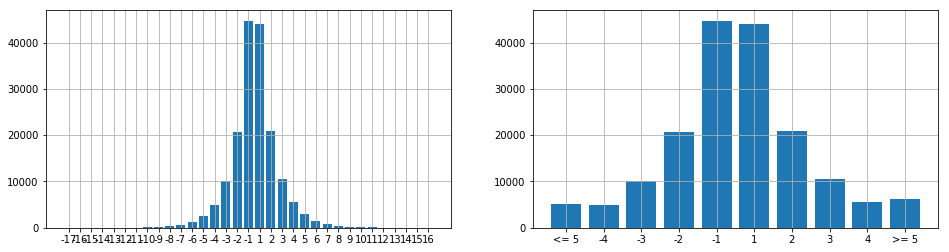

In [491]:
prior_streak_lim = 5
fig = plt.figure()
fig.set_size_inches(16, 4)
prior_streak_ls = sorted(list(prior_streak.keys()))
prior_streak_counts = np.asarray([len(prior_streak[l]) for l in prior_streak_ls])
g = fig.add_subplot(1, 2, 1)
g.grid()
g.bar(np.arange(len(prior_streak_ls)), prior_streak_counts)
plt.xticks(np.arange(len(prior_streak_ls)), prior_streak_ls)
prior_streak_grp = deepcopy([prior_streak[l] for l in prior_streak_ls if abs(l) <= prior_streak_lim])
prior_streak_grp[0] += sum([prior_streak[l] for l in prior_streak_ls if l < -prior_streak_lim], [])
prior_streak_grp[-1] += sum([prior_streak[l] for l in prior_streak_ls if l > prior_streak_lim], [])
prior_streak_ls_ = ['<= ' + str(prior_streak_lim)] + [l for l in prior_streak_ls if abs(l) < prior_streak_lim] + \
                   ['>= ' + str(prior_streak_lim)]
prior_streak_counts_ = np.asarray([len(prior_streak_grp[i]) for i in range(len(prior_streak_grp))])
g = fig.add_subplot(1, 2, 2)
g.grid()
g.bar(np.arange(len(prior_streak_ls_)), prior_streak_counts_)
plt.xticks(np.arange(len(prior_streak_ls_)), prior_streak_ls_)
plt.show()

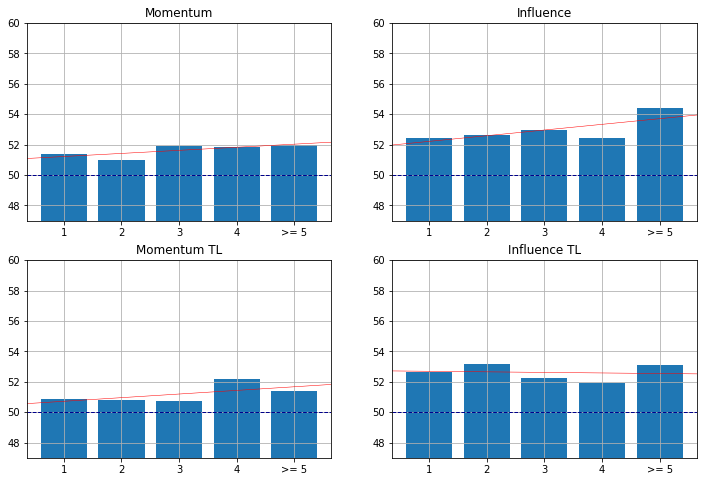

In [492]:
fig = plt.figure()
fig.set_size_inches(12, 8)
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
#     plt.ylim(45.0,  57.0)
#     plt.xlim(-0.75,  4.75)
    x_ = np.arange(len(prior_streak_grp[-prior_streak_lim:]))
    accs = []
    for i in range(len(prior_streak_grp[-prior_streak_lim:])):
        idx = prior_streak_grp[-prior_streak_lim:][i]
        accs.append(100 * np.mean(np.round(model_preds[m_i][idx]) == Y_ambiwin[idx]))
    accs = np.asarray(accs)
    g.bar(x_, accs)
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.xlim(*xlim)
    plt.ylim(47, 60)
    g.plot([-50, +50], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-50], [+50]]), color='red', lw=0.5)
    plt.xticks(x_, prior_streak_ls_[-prior_streak_lim:])
    g.set_title(list(models.keys())[m_i])
    g.axhline(y=50, color='darkblue', lw='1.0', ls='--')
# plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
plt.show()

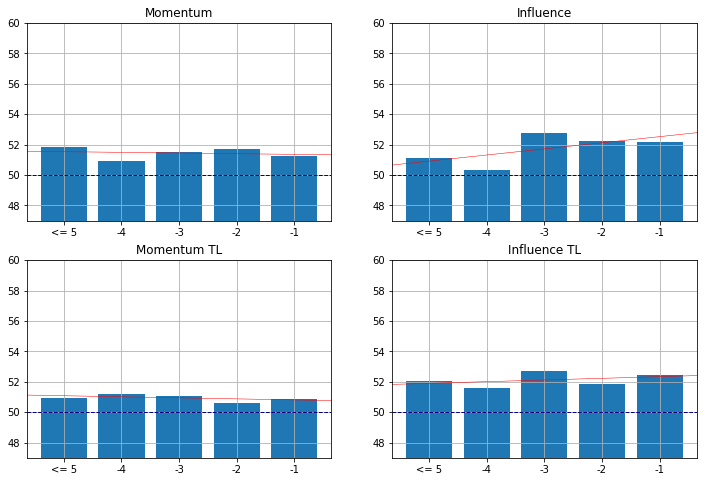

In [493]:
fig = plt.figure()
fig.set_size_inches(12, 8)
for m_i in range(len(models)):
    g = fig.add_subplot(2, 2, m_i + 1)
    g.grid()
#     plt.ylim(45.0,  57.0)
#     plt.xlim(-0.75,  4.75)
    x_ = np.arange(len(prior_streak_grp[:prior_streak_lim]))
    accs = []
    for i in range(len(prior_streak_grp[:prior_streak_lim])):
        idx = prior_streak_grp[:prior_streak_lim][i]
        accs.append(100 * np.mean(np.round(model_preds[m_i][idx]) == Y_ambiwin[idx]))
    accs = np.asarray(accs)
    g.bar(x_, accs)
    xlim, ylim = plt.xlim(), plt.ylim()
    plt.xlim(*xlim)
    plt.ylim(47, 60)
    g.plot([-50, +50], LinearRegression().fit(np.atleast_2d(x_).T, accs).predict([[-50], [+50]]), color='red', lw=0.5)
    plt.xticks(x_, prior_streak_ls_[:prior_streak_lim])
    g.set_title(list(models.keys())[m_i])
    g.axhline(y=50, color='darkblue', lw='1.0', ls='--')
# plt.savefig(graphs_folder + '/' + model_name + "_curve" + '.pdf', format='pdf')
plt.show()

In [166]:
n = 16310
simulation_winrates = scipy.stats.beta.rvs(16, 15.3, size=n)
wstreaksizes_sim = []
lstreaksizes_sim = []
for i in range(n):
    last_sample = None
    curr_str = None
    str_count = 0
    streaks = []
    for j in range(21):
        sample = (float(np.random.uniform() < simulation_winrates[i]) - 0.5) * 2
        if j > 0:
            if sample != last_sample:
                str_count += 1
                if str_count >= 2:
                    streaks.append(curr_str)
                curr_str = sample
            else:
                curr_str += sample
        else:
            curr_str = sample
        last_sample = sample
    wstreaksizes_sim.append(np.nan_to_num(np.mean([i for i in streaks if i > 0])))
    lstreaksizes_sim.append(-np.nan_to_num(np.mean([i for i in streaks if i < 0])))

c:\python36\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\python36\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-0.11302824812058918


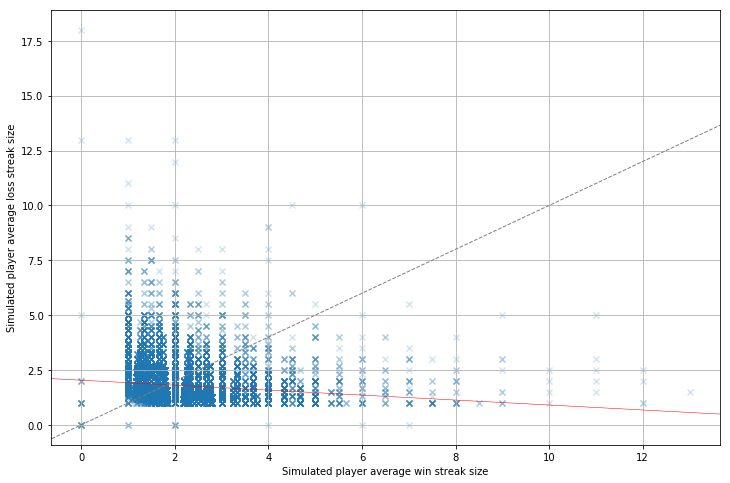

In [167]:
wstreaksizes_sim = np.asarray(wstreaksizes_sim)
lstreaksizes_sim = np.asarray(lstreaksizes_sim)
fig = plt.figure()
fig.set_size_inches(12, 8)
plt.scatter(wstreaksizes_sim, lstreaksizes_sim, marker='x', lw=1.5, alpha=0.2)
lr_x = [[-50], [+50]]
lr_y = TheilSenRegressor().fit(np.atleast_2d(wstreaksizes_sim).T, lstreaksizes_sim).predict(lr_x)
print((lr_y[1] - lr_y[0]) /(lr_x[1][0] - lr_x[0][0]))
xlim, ylim = plt.xlim(), plt.ylim()
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.plot(np.asarray(lr_x).flatten(), lr_y, color='red', lw=0.5)
plt.plot([-50, +50], [-50, +50], color="grey", lw=1.0, ls='--')
plt.xlabel("Simulated player average win streak size")
plt.ylabel("Simulated player average loss streak size")
plt.grid()
plt.show()

In [602]:
# # pliz = sum([[[s[0], pl_elos[i]] for s in pl_sessions[pl_id] if s[pl_sls["n_games"]] >= 19] for i, pl_id in enumerate(pl_ids)], [])
# pliz = sum([[[s[0], pl_elos[i]] for s in pl_sessions[pl_id]] for i, pl_id in enumerate(pl_ids)], [])
# pliz = np.asarray(pliz)
# len(pliz)

37793

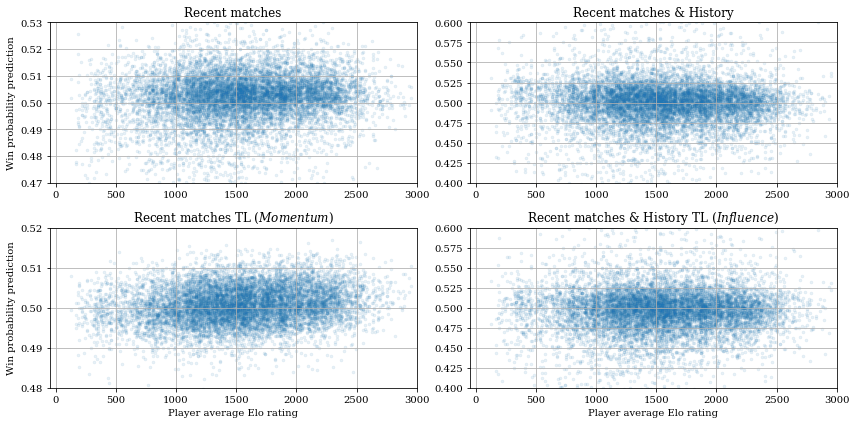

In [633]:
# n__ = 10000
# fig = plt.figure()
# fig.set_size_inches(12, 6)
# for m_i in range(len(models)):
#     g = fig.add_subplot(2, 2, m_i + 1)
# #     lr_x_elo = [[0], [4000]]
# #     yz_elo = [Ridge().fit(np.atleast_2d(pliz[:n__, 1]).T, model_preds[m_i][pliz[:n__, 0].astype(int)]).predict(lr_x_elo) for _ in range(10)]
# #     lr_y_elo = np.mean(yz_elo, axis=0)
# #     gradient_ = (lr_y_[1] - lr_y_[0]) / (lr_x[1][0] - lr_x[0][0])
# #     print(gradient_, np.mean(pl_folded[:, 2]))
#     g.scatter(pliz[:n__, 1], model_preds[m_i][pliz[:n__, 0].astype(int)], marker='.', lw=0.5, alpha=0.1)
# #     g.plot(lr_x_elo, lr_y_elo, color='red', lw=0.5)
#     g.grid()
#     g.set_title(list(models.keys())[m_i])
#     plt.ylim(0.4, 0.6)
#     plt.xlim(-50, 3000)
#     if m_i >= 2: plt.xlabel("Player average Elo rating")
#     if m_i % 2 == 0: plt.ylabel("Win probability prediction")
#     if m_i == 0: plt.ylim(0.47, 0.53)
#     if m_i == 2: plt.ylim(0.48, 0.52)
# #     if m_i == 3:
# #         g.legend()
# plt.tight_layout()
# plt.savefig(graphs_folder + '/elo_scatter.pdf', format='pdf')
# plt.show()